# Day 4 — Model Interpretability and Permutation Importance
### Machine Learning Roadmap — Week 4
### Author — N Manish Kumar
---

Tree-based models such as Random Forests provide built-in feature importance,
but these importance scores can be biased toward features with many possible
splits or high variance.

To obtain more reliable and model-agnostic explanations, we use
**permutation importance**, which measures how much model performance drops
when a feature’s values are randomly shuffled.

In this notebook, we will:
- Train a Random Forest model
- Examine built-in feature importance
- Compute permutation importance
- Compare both methods and interpret differences

Dataset used: **Breast Cancer Dataset (sklearn)**

---

## 1. Dataset Loading and Train/Test Split


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

Training shape: (455, 30)
Test shape: (114, 30)


---
## 2. Train Random Forest Baseline Model

Before interpreting feature importance, we first train a Random Forest model
and evaluate its performance on the test set.

Interpretability only makes sense if the model generalizes reasonably well.
If the model performs poorly, feature explanations are not meaningful.


In [2]:
# Train Random Forest 
rf = RandomForestClassifier(
    n_estimators = 200,
    random_state= 42,
    n_jobs = -1
)
rf.fit(X_train,y_train)

# Evaluate Performance
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print("Random Forest Train Accuracy:", train_acc)
print("Random Forest Test Accuracy:", test_acc)

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.956140350877193


### Interpretation

The Random Forest achieves high training accuracy and strong test accuracy,
indicating good generalization.

Since the model performs well on unseen data, we can confidently proceed
to interpret which features are driving its predictions.

---

## 3. Built-in Feature Importance from Random Forest

Random Forest provides feature importance based on how much each feature
reduces impurity (such as Gini impurity) across all trees in the ensemble.

This method is fast and commonly used, but it has known limitations:
- It can be biased toward features with many possible split points
- It may overemphasize correlated features

We compute and visualize built-in feature importance as a baseline before
using permutation importance.

In [4]:
# Exact built-in feature importance
rf_importance = rf.feature_importances_
importance_df = pd.DataFrame({
    "Feature": data.feature_names,
    "Importance": rf_importance
}).sort_values(by="Importance",ascending=False)

importance_df.head(10)

,Feature,Importance
22,worst perimeter,0.133100
23,worst area,0.128052
27,worst concave points,0.108107
7,mean concave points,0.094414
20,worst radius,0.090639
0,mean radius,0.058662
2,mean perimeter,0.055242
3,mean area,0.049938
6,mean concavity,0.046207
26,worst concavity,0.035357


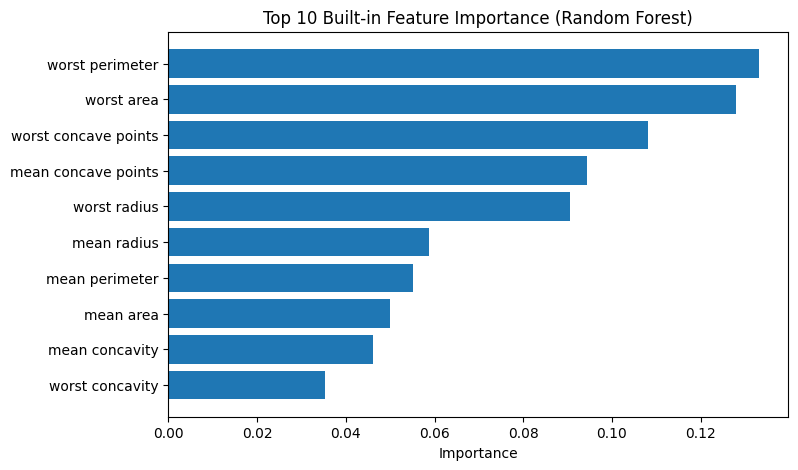

In [6]:
# Plot top 10 features
top_features = importance_df.head(10)

plt.figure(figsize =(8,5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Built-in Feature Importance (Random Forest)")
plt.show()

### Interpretation

The most important features are those that frequently reduce impurity across
many trees in the forest.

While this provides a useful first look, these importance values may be biased
toward continuous or high-variance features.

To obtain more reliable, model-agnostic explanations, we next use
permutation importance.

---

## 4. Permutation Importance (Model-Agnostic)

Permutation importance measures how important a feature is by observing how
much the model’s performance decreases when that feature’s values are randomly
shuffled.

Key idea:
- If shuffling a feature causes a large drop in accuracy, the model relied
  heavily on that feature.
- If performance does not change much, the feature was not very important.

Advantages:
- Works with any model
- Measures importance based on actual prediction performance
- Less biased than impurity-based importance

We compute permutation importance using the test set so that importance reflects
generalization behavior.


In [8]:
# Compute Permutation Importance on test set
perm_importance = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": data.feature_names,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

perm_df.head(10)

,Feature,Importance
3,mean area,0.008772
15,compactness error,0.008772
22,worst perimeter,0.008772
23,worst area,0.007895
7,mean concave points,0.007895
0,mean radius,0.007018
21,worst texture,0.007018
20,worst radius,0.007018
17,concave points error,0.006140
27,worst concave points,0.005263


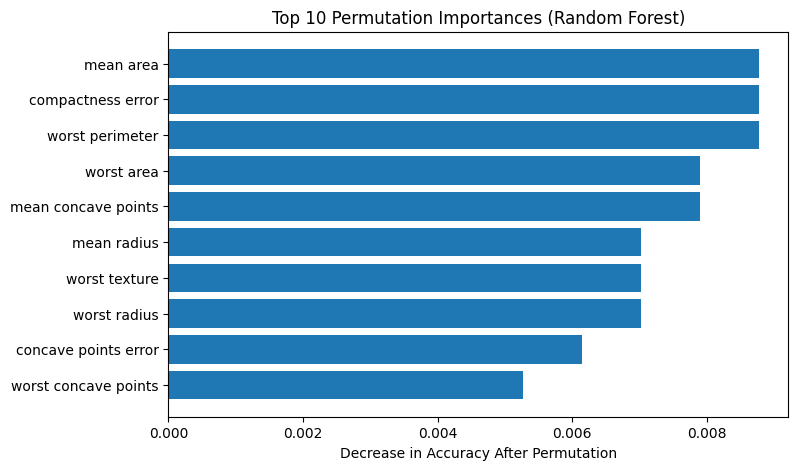

In [9]:
# Plot top 10 permutation importance features
top_perm = perm_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_perm["Feature"], top_perm["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Decrease in Accuracy After Permutation")
plt.title("Top 10 Permutation Importances (Random Forest)")
plt.show()

### Interpretation

Permutation importance reflects how much the model’s predictive performance
depends on each feature.

Features with large drops in accuracy when permuted are crucial for correct
predictions.

Compared to built-in feature importance, permutation importance often provides
a more realistic and trustworthy ranking of influential features.

---

## 5. Comparing Built-in and Permutation Importance

Different feature importance methods answer different questions:

- Built-in importance measures how often and how effectively a feature is used
  for splitting inside the Random Forest.
- Permutation importance measures how much the model's predictive performance
  depends on a feature.

Comparing both side-by-side helps identify:
- Stable, genuinely important features
- Features that appear important due to model bias or correlation


In [10]:
# Merge both importance measures
comparison_df = importance_df.merge(
    perm_df,
    on="Feature",
    suffixes=("_BuiltIn","_Permutation")
)

comparison_df.head(10)

,Feature,Importance_BuiltIn,Importance_Permutation
0,worst perimeter,0.133100,0.008772
1,worst area,0.128052,0.007895
2,worst concave points,0.108107,0.005263
3,mean concave points,0.094414,0.007895
4,worst radius,0.090639,0.007018
5,mean radius,0.058662,0.007018
6,mean perimeter,0.055242,0.004386
7,mean area,0.049938,0.008772
8,mean concavity,0.046207,0.000877
9,worst concavity,0.035357,0.000000


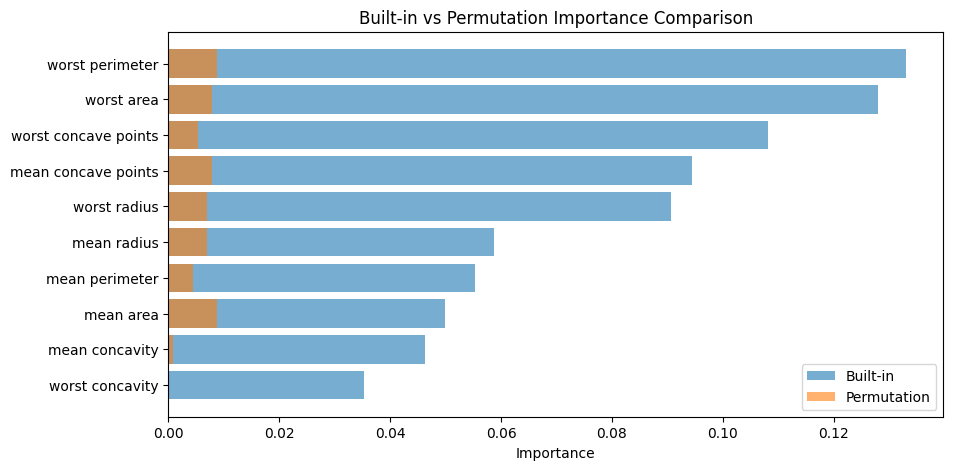

In [11]:
# Compare top 10 features from both methods
top_compare = comparison_df.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_compare["Feature"], top_compare["Importance_BuiltIn"], alpha=0.6, label="Built-in")
plt.barh(top_compare["Feature"], top_compare["Importance_Permutation"], alpha=0.6, label="Permutation")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Built-in vs Permutation Importance Comparison")
plt.legend()
plt.show()

### Interpretation

Features that rank highly in both methods are strong and reliable predictors.

Features that rank high only in built-in importance may be benefiting from
split bias or correlation effects.

Permutation importance highlights which features truly affect prediction
accuracy, making it more suitable for trustworthy model explanations.

---
# Notebook Summary — Week 4 Day 4

In this notebook, we focused on understanding and comparing different methods
for interpreting tree-based models.

### What was done
- Trained a Random Forest model on the Breast Cancer dataset
- Verified model performance before interpretation
- Extracted built-in feature importance from Random Forest
- Computed permutation importance using the test set
- Compared built-in and permutation importance side-by-side

### Key Learnings
- Built-in feature importance can be biased toward certain features
- Permutation importance is model-agnostic and based on prediction performance
- Features important for splits are not always the same as features important
  for predictions
- Reliable model interpretation requires multiple explanation methods

### Final Outcome
Permutation importance provided more trustworthy feature rankings, improving
confidence in model explanations and making the Random Forest model more
interpretable for real-world use.